# Analyzing Chatbot Conversations

This data science notebook analyzes the log of all conversations between users and the chatbot to help understand how the chatbot is performing. 

### Prerequisites
We're going to use PixieDust to help visualize our data. You can learn more about PixieDust at https://ibm-cds-labs.github.io/pixiedust/.
In the following cell we ensure we are running the lastest version of PixieDust. Be sure to restart your kernel if instructed to do so.

In [25]:
!pip install --user --upgrade pixiedust

▸,:,


Requirement already up-to-date: pixiedust in /gpfs/global_fs01/sym_shared/YPProdSpark/user/scf4-c5b9b40849ac63-99f3c8a123f6/.local/lib/python2.7/site-packages
Requirement already up-to-date: lxml in /gpfs/global_fs01/sym_shared/YPProdSpark/user/scf4-c5b9b40849ac63-99f3c8a123f6/.local/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: mpld3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/scf4-c5b9b40849ac63-99f3c8a123f6/.local/lib/python2.7/site-packages (from pixiedust)


In [26]:
import pixiedust
pixiedust.enableJobMonitor()

▸,:,


Spark Job Progress Monitor already enabled


In [27]:
from pyspark.sql.functions import explode, lower

▸,:,


### Configure database connectivity
Enter your Cloudant information below.

In [28]:
# Enter your Cloudant host name
host = 'adc809a8-9e28-41c4-bfac-faf3e36a9862-bluemix.cloudant.com'
# Enter your Cloudant user name
username = 'roseepeandstookedookedis'
# Enter your Cloudant password
password = 'e289a36b93296c479d3240e477fdfa14c58f3577'
# Enter your source database name
database = 'cbf_chatbot_convos'

▸,:,


### Load documents from the database
Load the documents into an Apache Spark DataFrame.

In [29]:
# obtain SparkSession
sparkSession = SparkSession.builder.getOrCreate()
# load data
conversation_df = sparkSession.read.format("com.cloudant.spark").\
    option("cloudant.host", host).\
    option("cloudant.username", username).\
    option("cloudant.password", password).\
    load(database)

▸,:,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Document Structure

Each document in the database represents a single conversation made with the chatbot. Each conversation includes the user, date, and the steps of the conversation. The steps are stored in an array called dialogs (referring to the dialogs in Watson Conversation that were traversed as part of the conversation). Here is a sample conversation:

<code>
"_id": "19e231d78c7106b61993bd3aacc77520",
"_rev": "3-3dad296b493c1cf2f12fc1a082661f82",
"userId": "iLhfu20E",
"date": 1494347114492,
"dialogs": [
  {
    "name": "sickGetSymptoms",
    "message": "I'm not feeling well",
    "reply": "I'm sorry to hear that. Why don't you tell me what is bothering you?\n",
    "date": 1494347114695
  },
  {
    "name": "sickENTSymptoms",
    "message": "I have a sore throat",
    "reply": "OK. It sounds like an ENT might be able to help you. Give me your address and I'll try and find one nearby.\n",
    "date": 1494347121729
  }
]
</code>

In the following cell we print the schema to confirm the structure of the documents.

In [30]:
conversation_df.printSchema()

▸,:,


root
 |-- _id: string (nullable = true)
 |-- _rev: string (nullable = true)
 |-- date: long (nullable = true)
 |-- dialogs: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- date: long (nullable = true)
 |    |    |-- message: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- reply: string (nullable = true)
 |-- userId: string (nullable = true)



### How many conversations where there?
Let's start by showing how many conversations there have been with the Chatbot: 

In [31]:
conversation_df.count()

▸,:,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

145

<IPython.core.display.Javascript object>

### Flatten the Cloudant JSON document structure
Each dialog contains a message field, which contains the message sent by the user, and a name field, which represents the action and dialog traversed by Watson Conversation for that message. For example, the name `findDoctorLocation` maps to the action of searching for a doctor. We want to do some analysis on specific actions and the messages associated with those actions, so in the next cell we convert each row (which has the dialog array) into multiple rows - one for each dialog. This will make it easier for us to filter and aggregate based on the message and name fields in the dialogs.

In [32]:
dialog_df = conversation_df.select(explode(conversation_df.dialogs).alias("dialog"))
dialog_df = dialog_df.select("dialog.date", 
                             lower(dialog_df.dialog.message).alias("message"),
                             "dialog.name",
                             "dialog.reply")
dialog_df.printSchema()

▸,:,


root
 |-- date: long (nullable = true)
 |-- message: string (nullable = true)
 |-- name: string (nullable = true)
 |-- reply: string (nullable = true)



In [33]:
dialog_df.count()

▸,:,


<IPython.core.display.Javascript object>

330

<IPython.core.display.Javascript object>

### Display Dialogs in PixieDust
Below we display each dialog in a PixieDust table. You can see the date, message (the message the user sent to the chatbot), name (the name of the action performed), and the reply sent to the user.

In [34]:
display(dialog_df)

date,message,name,reply
1494381118277,ok,unhandled,"Sorry, I'm not sure what you mean. I can help you if you're feeling sick, find a doctor, or find a pharmacy."
1494383220321,ok,unhandled,"Sorry, I'm not sure what you mean. I can help you if you're feeling sick, find a doctor, or find a pharmacy."
1494383297876,ok,unhandled,"Sorry, I'm not sure what you mean. I can help you if you're feeling sick, find a doctor, or find a pharmacy."
1494383332042,ok,unhandled,"Sorry, I'm not sure what you mean. I can help you if you're feeling sick, find a doctor, or find a pharmacy."
1494386684962,hello,unhandled,"Sorry, I'm not sure what you mean. I can help you if you're feeling sick, find a doctor, or find a pharmacy."
1494381163659,ok,unhandled,"Sorry, I'm not sure what you mean. I can help you if you're feeling sick, find a doctor, or find a pharmacy."
1494381167622,ok,unhandled,"Sorry, I'm not sure what you mean. I can help you if you're feeling sick, find a doctor, or find a pharmacy."
1494298027332,hello,unhandled,"Sorry, I'm not sure what you mean. I can help you blah blah blah"
1494299159246,hello,unhandled,"Sorry, I'm not sure what you mean. I can help you if you're feeling sick, find a doctor, or find a pharmacy."
1494345998794,hello,unhandled,"Sorry, I'm not sure what you mean. I can help you if you're feeling sick, find a doctor, or find a pharmacy."


### How many conversations started with people saying they were sick?
The action `sickGetSymptoms` is stored when a user says they are not feeling well. Here we create a DataFrame with only those search actions:

In [35]:
sick_dialog_df = dialog_df.filter(dialog_df.name == 'sickGetSymptoms')
sick_dialog_df.count()

▸,:,


<IPython.core.display.Javascript object>

10

<IPython.core.display.Javascript object>

### How many symptoms did we match?
Here we'll filter the DataFrame down to only those rows where the dialog name equals 'sickENTSymptoms' or 'sickOtherSymptoms'.
These dialogs are called when the user enters a message that contains a symptom that is defined in our @specialty entity in Watson Conversation.

In [36]:
known_symptom_dialog_df = dialog_df.filter((dialog_df.name == 'sickENTSymptoms') | (dialog_df.name == 'sickOtherSymptoms'))
known_symptom_dialog_df.count()

▸,:,


<IPython.core.display.Javascript object>

6

<IPython.core.display.Javascript object>

### How many symptoms did we miss?
Here we'll filter the DataFrame down to only those rows where the dialog name equals 'sickUnknownSymptoms'.
This dialog is called when the user enters a message that *DOES NOT* contain a symptom that is defined in our @specialty entity.

In [37]:
unknown_symptom_dialog_df = dialog_df.filter(dialog_df.name == 'sickUnknownSymptoms')
unknown_symptom_dialog_df.count()

▸,:,


<IPython.core.display.Javascript object>

4

<IPython.core.display.Javascript object>

### Matches vs. Misses
Here we'll throw the match count and miss count into a DataFrame and use PixieDust to display a pie chart comparing the two.


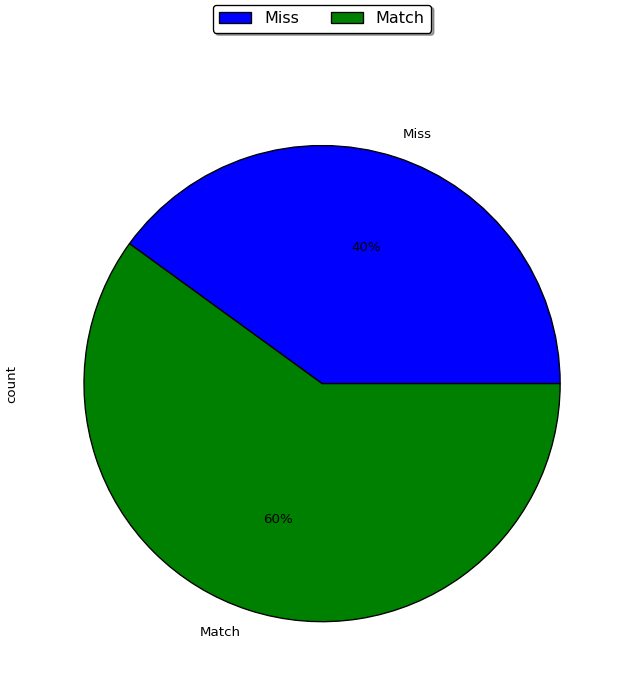

In [38]:
sparkSession = SparkSession.builder.getOrCreate()
match_vs_miss_df = sparkSession.createDataFrame(
[('Match', known_symptom_dialog_df.count()),
 ('Miss', unknown_symptom_dialog_df.count())],
["name","count"])

display(match_vs_miss_df)

### Drill down into the misses
Here we'll try and pick out the most common symptoms that we missed.
Since we only have the full message sent by the user we're going to split it up into words, filter out stop words,
and look at the most common words. Something like 'sore throat' will be broken up into 'sore' and 'throat', so this analysis won't be perfect,
but it should hopefully give us an idea of what we're missing.


In [39]:
!pip install stop-words

▸,:,


In [40]:
import re
import stop_words

▸,:,


In [41]:
def parseMessage(msg):
    msg = re.sub("[^a-zA-Z ']", "", msg)
    msgWords = re.split("\s+", msg.lower())
    msgWords = filter(lambda w: w not in "", msgWords)
    stopWords = stop_words.get_stop_words('en')
    return filter(lambda w: w not in stopWords, msgWords)

▸,:,


In [42]:
rdd = unknown_symptom_dialog_df.rdd.flatMap(lambda row: parseMessage(row['message']))

▸,:,


In [43]:
rdd = rdd.map(lambda x: (x,1)).reduceByKey(lambda x, y: x + y)

▸,:,


In [44]:
rdd.take(10)

▸,:,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[(u'itchy', 1),
 (u'sick', 1),
 (u'hello', 1),
 (u'toothache', 1),
 (u'im', 1),
 (u'eyes', 1)]

<IPython.core.display.Javascript object>

In [45]:
unknown_symptom_dialog_by_word_df = rdd.toDF(['word','count']).orderBy('count', ascending=False)
display(unknown_symptom_dialog_by_word_df)

word,count
itchy,1
sick,1
hello,1
eyes,1
toothache,1
im,1


### Chart Top 10 Misses
Here we'll visualize the top ten missed words in a bar chart.


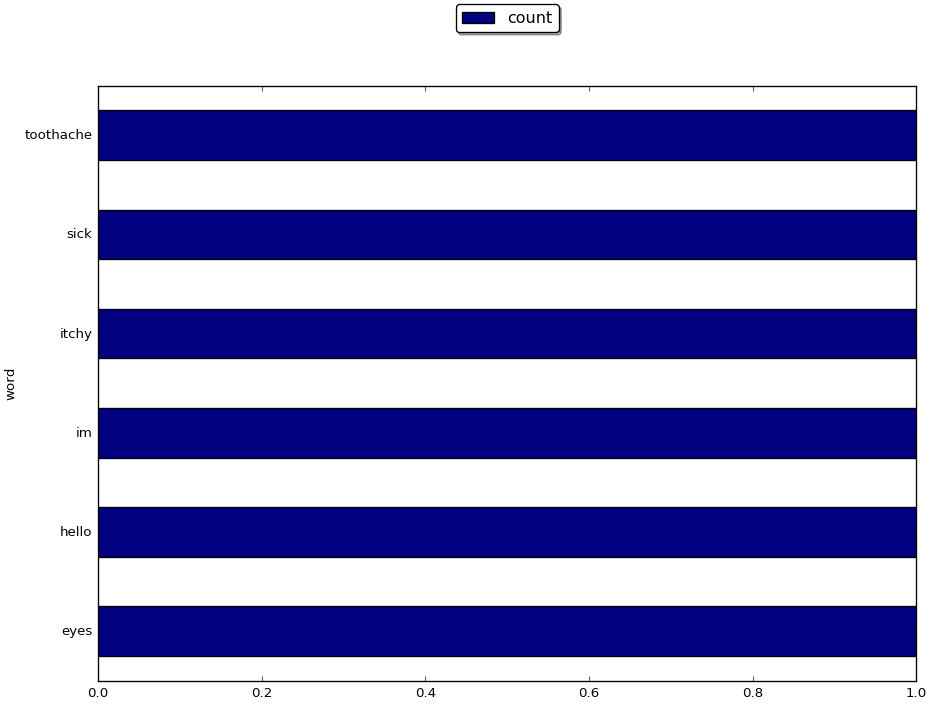

In [46]:
display(unknown_symptom_dialog_by_word_df.limit(10))